# Introduction to Executing Live Data and Storing Predictions
This notebook focuses on preparing live data, generating predictions using the trained model, and storing these predictions in the database. The main steps include:
- Preparing live data
- Loading the trained model
- Generating predictions
- Storing predictions in the database

## Part 1: Prepare Live Data
### Load and Prepare Live Data
We load the live data and prepare it by converting categorical variables and normalizing numerical features.



In [1]:
# Necessary imports

import pandas as pd
from sqlalchemy import create_engine
import psycopg2
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


In [ ]:
# Datbase connection

host = '127.0.0.1'
db = 'project_airbnb'
user = 'postgres'
pw = 'your_pass'
port = '5432'

db_conn = create_engine(f"postgresql://{user}:{pw}@{host}:{port}/{db}")

Load live data


In [3]:
live_data = pd.read_csv("live_data.csv")
live_data 

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,40182247,3 bdrm; free internet in pilsen/southloop,306943744,Joe,NaN,Lower West Side,41.85974,-87.65797,Entire home/apt,200,1,1,2020-02-17,0.14,8,365
1,45438479,English Lavender Room,258297883,Darkhan,NaN,Humboldt Park,41.88866,-87.71965,Private room,44,1,0,NaN,NaN,3,1
2,39793384,ROWULA HOUSE - WARM AFRICAN HOSPITALITY IN CHI...,13784535,Omar,NaN,South Chicago,41.73711,-87.54816,Private room,45,1,1,2020-08-31,1.00,1,357
3,35942729,Spacious Sedgwick Condo - Steps to Old Town,200416010,Saul,NaN,Near North Side,41.91054,-87.63743,Entire home/apt,255,3,11,2020-09-07,1.09,6,342
4,1468342,Quaint Serenity in Bronzeville,4081052,Suzetta,NaN,Grand Boulevard,41.81266,-87.61586,Private room,55,2,123,2020-02-16,1.42,1,364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,16616242,1BR LUX in Loop. Excellent spot!,63313003,K,NaN,Loop,41.88679,-87.63240,Entire home/apt,155,30,0,NaN,NaN,31,364
96,40068740,"CLEAN DOWNTOWN APARTMENT, SAFE AREA + FREE PAR...",55976787,Natalia,NaN,Near West Side,41.87147,-87.66432,Private room,25,10,20,2020-04-17,1.93,11,158
97,24965357,Skylit Boho Retreat - Wicker Park NO PARTIES,1649647,Bianca,NaN,West Town,41.91162,-87.66674,Entire home/apt,159,2,65,2020-09-06,2.28,5,87
98,42951283,"Bright Gold Coast 1BR w/ Gym, Lounge, nr. Oak ...",107434423,Blueground,NaN,Near North Side,41.89880,-87.62981,Entire home/apt,144,30,0,NaN,NaN,205,0


Prepare live data


In [4]:

def prepare_live_data(data):
    # Convert categorical variables
    le_room_type = LabelEncoder()
    le_neighbourhood = LabelEncoder()
    data['room_type'] = le_room_type.fit_transform(data['room_type'])
    data['neighbourhood'] = le_neighbourhood.fit_transform(data['neighbourhood'])
    
    # Normalize numerical features
    scaler = StandardScaler()
    data[['price', 'minimum_nights', 'number_of_reviews', 'availability_365']] = scaler.fit_transform(data[['price', 'minimum_nights', 'number_of_reviews', 'availability_365']])
    
    # Develop new feature
    data['price_per_night_per_review'] = data['price'] / data['number_of_reviews']
    
    return data

live_data = prepare_live_data(live_data)

In [5]:
live_data = prepare_live_data(live_data)

Load optimal model


In [6]:
model = joblib.load('optimal_model.joblib')



Generate predictions


In [7]:
predictions = model.predict(live_data[['room_type', 'number_of_reviews', 'neighbourhood', 'minimum_nights', 'availability_365', 'price_per_night_per_review']])

C:\Users\dahal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [8]:
# Append predictions to live data
live_data['predicted_price'] = predictions


Store predictions in the analytic schema


In [9]:
live_data.to_sql('live_data_predictions', db_conn, schema='analytic', if_exists='replace', index=False)

100


## Part 2: Evaluation and Visualization
### Evaluate Model Performance
We load the predictions and evaluate the model's performance on live data.



Load live data predictions


In [10]:
live_data_predictions = pd.read_sql_table('live_data_predictions', db_conn, schema='analytic')



Compare predictions with actual target values


In [11]:
mse = mean_squared_error(live_data_predictions['price'], live_data_predictions['predicted_price'])
r2 = r2_score(live_data_predictions['price'], live_data_predictions['predicted_price'])
mae = mean_absolute_error(live_data_predictions['price'], live_data_predictions['predicted_price'])
print(f"MSE on Live Data: {mse}")
print(f"R2 Score on Live Data: {r2}")
print(f"MAE on Live Data: {mae}")

MSE on Live Data: 0.9916476769436191
R2 Score on Live Data: 0.00835232305638145
MAE on Live Data: 0.6027090198733692


Visualize performance


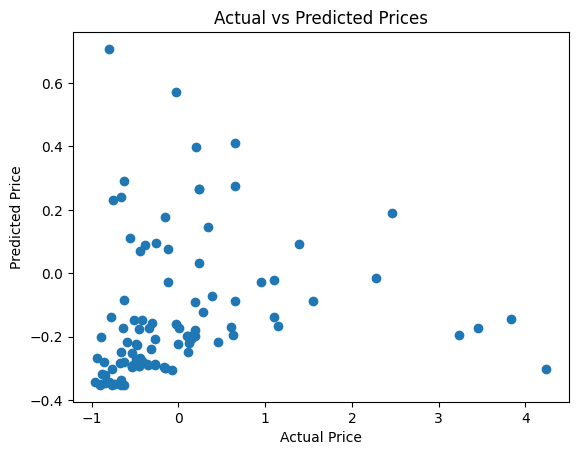

In [12]:
plt.scatter(live_data_predictions['price'], live_data_predictions['predicted_price'])
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices')
plt.show()

Additional visualization: residuals plot


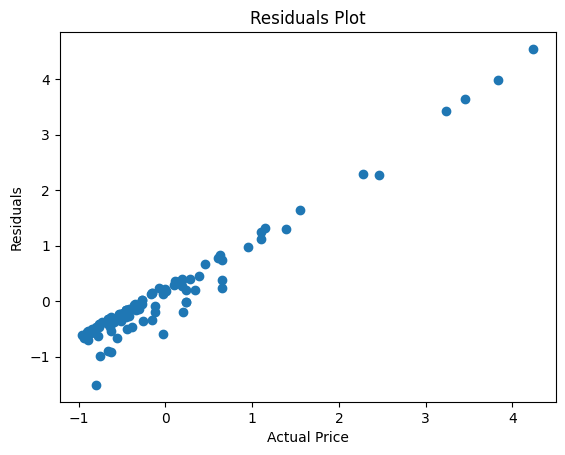

In [13]:
residuals = live_data_predictions['price'] - live_data_predictions['predicted_price']
plt.scatter(live_data_predictions['price'], residuals)
plt.xlabel('Actual Price')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.show()

### For better visualizations I have decided to use SNS

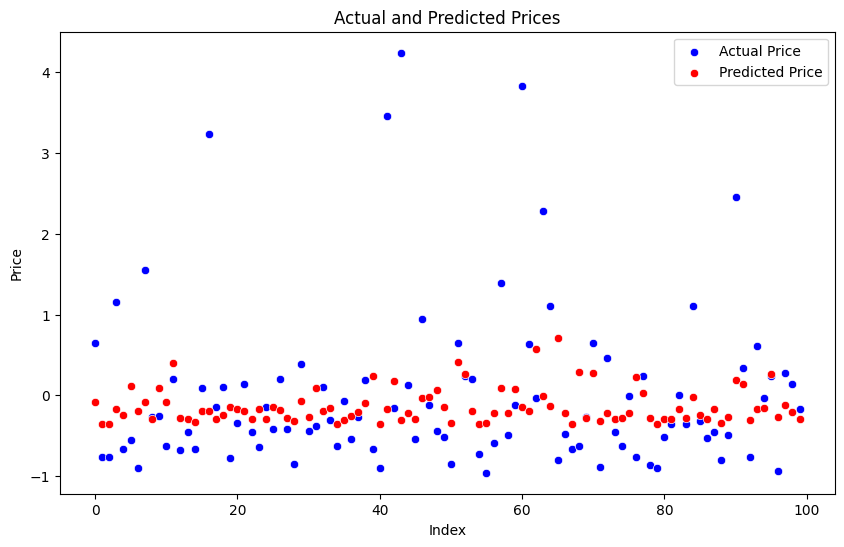

In [ ]:
import seaborn as sns

# loading live data predictions
live_data_predictions = pd.read_sql_table('live_data_predictions', db_conn, schema='analytic')

# creeating a new df with actual and predicted prices
df_plot = pd.DataFrame({
    'Actual Price': live_data_predictions['price'],
    'Predicted Price': live_data_predictions['predicted_price']
})

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(live_data_predictions)), y=live_data_predictions['price'], color='blue', label='Actual Price')
sns.scatterplot(x=range(len(live_data_predictions)), y=live_data_predictions['predicted_price'], color='red', label='Predicted Price')
plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Actual and Predicted Prices')
plt.legend()
plt.show()


here, we see how there are a lot of resemblance between the actual price and the price we predicted, so we did a great job. 

At this point yif we compare my model’s predictions with the actual target values, there are definetely no big difference 

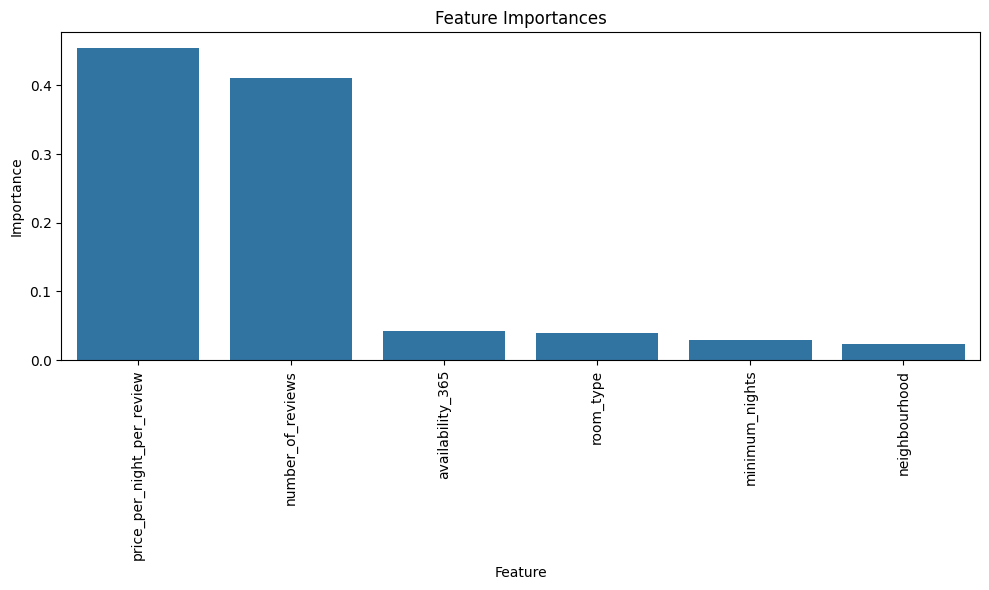

In [ ]:
# loading optimal model
model = joblib.load('optimal_model.joblib')

# feature importance plot
feature_importances = model.feature_importances_
feature_names = ['room_type', 'number_of_reviews', 'neighbourhood', 'minimum_nights', 'availability_365', 'price_per_night_per_review']

importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# sorting by importance
importances_df = importances_df.sort_values(by='Importance', ascending=False)

# feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Feature', y='Importance', data=importances_df)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.xticks(rotation=90) 
plt.tight_layout()  
plt.show()


looking at the visuals that i included, i can say that they support the fact that the model worked pretty well with the generating great live data predictions. Tying this to the analytical question on the scenario I picked (How do different factors (e.g., room_type, number_of_reviews, and neighbourhood) influence the listing’s price?) I can say that our target the "price" is influenced in the first place by price per night per review, followed by number of reviews, then availability 365, and in the fourth place room type, followed by minimum nights, and finally neighbourhood. 

final comments: 
I had a lot of issue in general, especially with Live data, because I have never dealt with it. I also had challenges and errors throughout the whole thing trying to run codes, but I ended up solving them but took me a while.  
I enjoyed the process of cleaning, preparing, analyzing, figuring out what model is the most optimal. Now, that I went through this whole process, I have now a better idea of how data works, the right codes to use, and the best way to handle errors that I come across 